
<figure>
<img src="assets/ForestFireCartoon.jpg" width="600">
<figcaption align = "center"> Image by pvproductions on Freepik: ”https://www.freepik.com/free-photo/fire-forest-flames-generative-ai_39872388.htm#query=forest%20fire&position=1&from_view=search&track=ais"</figcaption>
</figure>



# Learning Objectives

- Apply finetuning methodolgy to create a custom model for predicting forest fire likelyhoods two years in advance
- Describe Intel(r) Extension for PyTorch* (IPEX) and how it can be applied to access Intel* gpus
- Describe how IPEX can ne used to accelerate a single model such as ResNet ot a pipleine of models such as Stable Diffusion*
- Apply code changes to required to utilize Intel® Data Center GPU Max 1100 and how to accelerate it for inference using IPEX
- Describe the acceleration you acheived by utilizing IPEX optimizations for this Stable Diffusion* model

# Background

This workshop, follows the article **["Predict Forest Fires using PyTorch"](https://medium.com/@zmadscientist/predict-forest-fires-using-pytorch-333e3d6f01ac)**, by Bob CHesebrough.

Forest fires threaten very often cause damages and loses of human lives, ecosystems, and wildlife. Early identification of high fire likelihood areas is a highly important aid in early deployment of counter fire measures for prescribed burns or developing road access or other early prevention measures. AccuWeather Founder and CEO Dr. Joel N. Myers stated that the 

- "total damage and cumulative economic loss for the **2021 wildfire season** was expected to be between **\\$70 billion** and **\\$90 billion** in the U.S. with **\\$45 billion** to **\\$55 billion** of those damages to California alone".

In this article, I propose using transfer learning using **PyTorch** to classify aerial photos according to the fire danger they convey using image details only. I use the **MODIS Buran Area dataset** to establish known fire burn areas in California from 2018 to 2020. I then sample aerial images acquired from **USDA/NAIP/DOQQ dataset** from the **prior two year period**, 2016 to 2017 in areas within and near the establish future fire regions. 

Then I use fine tuning learning to adapt a pretrained **Resnet 18 model** (never trained on aerial photos) and use transfer learning on on either a **4th Gen Intel® Xeon processor** or on a **Intel® Data Center GPU Max Series**, The model is trained on a couple hundred images and labels for Fire and NoFire images. I then demonstrate how well the model works — read on for more details!

My model is more of a spatial-temporal model of sorts but more emphasis is on spatial prediction of where fires are likely to occur and then tested in the following 2 year interval.

Traditional methods have been employed for many years to forecast these fires, but with new AI based algorithms, now we have the potential to enhance the predictability of forest fires. In this article, I will briefly explore the importance of predicting forest fires, and then delve into my case study of using Resnet classifier in conjunction with the **MODIS Burn Area data set** to label future fire locations from the 2016 perspective.

Early detection can aid in early deployment of counter fire measures for prescribed burns or developing road access or other early prevention measures. It may also be useful for estimating the potential economic impact on industries such as agriculture, timber, and tourism, etc. allowing for better preparedness.

# Overview of Finetuning Project

The purpose of this series of notebooks on Finetuning is to experiment with using aerial photos as a basis for predicting forest fire likelyhood based on the Modis datasets using **[Google Earth Engine](https://code.earthengine.google.com/)** or the **[USGS Earth Explorer](https://earthexplorer.usgs.gov/)** **USDA/NAIP/DOQQ aerial photos** and **MODIS Burn Area datasets** - all from within the State of California.

For this workshop, however, in order to provide the data for the lab, we have provided synthetic data.

The discussion that follows in this notebook, is from actual data from NAIP from 2016-2017 and the MODIS data is filtered to show the fires in CA from 2018 thru 2020.

<figure>
<img src="assets/ModisSampling.png" width="600">
<figcaption align = "center"> Figure 1. Sampled locations used: Google Earth Engine with MODIS/006/MCD641 dataset </figcaption>
</figure>

In Figure 1. I plot the a map of images locations that can be used to predict forest fire using these techniques using real world data, such as that acquired from Google Earth Engine NAIP/DQQQ aerial photos with True Color*

# Sampling Method

I used the Modis datasets to identify which regions in CA had been burned in forest fires in the period from 2018 to 2020.

I then collected images from these same regions from the period 2016 to end of 2017 and used the pre-burn images from both known fire and non-fire regions to make a resnet 18 binary model to predict Fire or NoFire for a given image.

The sampling index map is displayed below for both the FIre and NoFire cases showing the locations we sampled with aerial photos.
tions.
/>

## Fire Samples
I sampled the MODIS burn area (red polygons) by "human random" means to simply identify the lattitudes and longitudes of Both Fire and NoFire regions. The MODIS burn area are the Red polygons, the cyan pins are my intended sample locations.

<figure>
<img src="assets/CA Burn areas 2018 to 2021 sampled.png", width="700">
<figcaption align = "center"> Figure 2. Sampled known fire locations used: Google Earth Engine with MODIS/006/MCD64A1 dataset </figcaption>
</figure>



## NoFire Samples

I sampled the MODIS NON burn area (NOT the red polygons) by "human random" means. The MODIS burn area are the Red polygons, the darker blue/teal pins are my intended sample locations



<figure>
<img src="assets/CA No Burn areas 2018 to 2020 sampled.png" width="500">
<figcaption align = "center"> Figure 3. Sampled non fire locations used: Google Earth Engine with MODIS/006/MCD64A1 dataset </figcaption>
</figure>

# Use MODIS Burn Area related polygons 

Hand drawn polygons approximating the MODIS fire region for Northern California from 2016 through 2017

In [1]:
import numpy as np
ModisOutlineParadise = np.load('data/ModisOutlineParadise.npy')
ModisOutlineNorth = np.load('data/ModisOutlineNorth.npy')
ModisOutlineWest = np.load('data/ModisOutlineWest.npy' )

# Function to test whether or no a given latitude, longitude is inside or outside the specified polygon

In [2]:
def point_in_polygon(point, polygon):
    x, y = point
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

## MODIS Regions Ideal Sampling

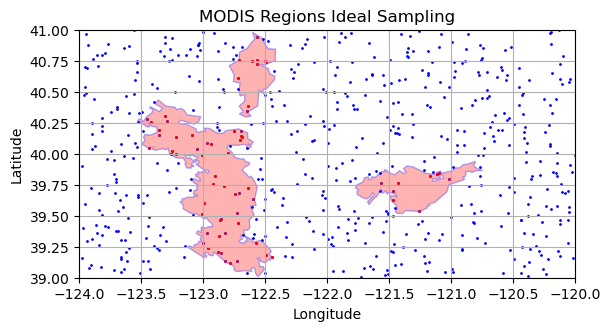

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as GPoly

N_rnd = 600
np.random.seed(42)

polyP = Polygon(ModisOutlineParadise, closed=True,  fc=(1,0,0,0.3),  ec=(0,0,1,0.3))
polyW = Polygon(ModisOutlineWest,     closed=True,  fc=(1,0,0,0.3), ec=(0,0,1,0.3))
polyN = Polygon(ModisOutlineNorth,    closed=True,  fc=(1,0,0,0.3), ec=(0,0,1,0.3))

fig, ax = plt.subplots()

ax.add_patch(polyP)
ax.add_patch(polyN)
ax.add_patch(polyW)

# Plot the line segments joining the vertices

xp, yp = zip(*ModisOutlineParadise)
xw, yw = zip(*ModisOutlineWest)
xn, yn = zip(*ModisOutlineNorth)
xmin = min(min(xp),min(xw),min(xn))
xmax = max(max(xp),max(xw),max(xn))

ymin = min(min(yp),min(yw),min(yn))
ymax = max(max(yp),max(yw),max(yn))

xrnd = 4*np.random.sample(N_rnd) - 124
yrnd = 2*np.random.sample(N_rnd) + 39

# Color all points blue at first
Modis = np.vstack([ModisOutlineWest, ModisOutlineNorth, ModisOutlineParadise])
polyWG = GPoly(Modis)
prnd = np.array(list(zip(xrnd, yrnd)))
plt.scatter(xrnd, yrnd, s= 1, c='b')

# Color ModisOutlineWest points red
test = []
for point in prnd:
    test.append(point_in_polygon(point, ModisOutlineWest))
test = np.array(test)
plt.scatter(xrnd[test==True], yrnd[test==True], s= 1, c='r')

# Color ModisOutlineNorth points red
test = []
for point in prnd:
    test.append(point_in_polygon(point, ModisOutlineNorth))
test = np.array(test)
plt.scatter(xrnd[test==True], yrnd[test==True], s= 1, c='r')

# Color ModisOutlineParadise points red
test = []
for point in prnd:
    test.append(point_in_polygon(point, ModisOutlineParadise))
test = np.array(test)
plt.scatter(xrnd[test==True], yrnd[test==True], s= 1, c='r')


# Set the aspect ratio and limits
plt.gca().set_aspect('equal')
plt.xlim(-124, -120)
plt.ylim(39.0, 41.0)
plt.grid()
# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MODIS Regions Ideal Sampling')
#s = [1+10*i for i in range(len(x))]

# Show the plot
plt.show()


## MODIS Regions actual Sampling

Number in Paradise 9
Number in West 48
Number in North 10
Number of Fire Samples 67


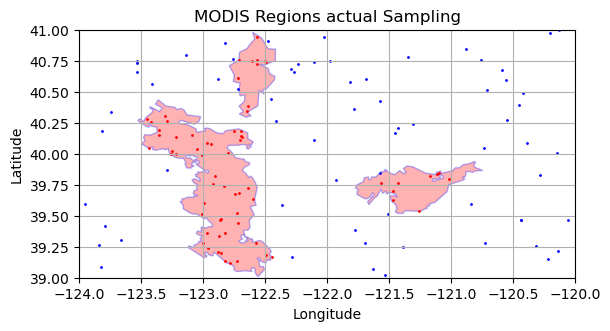

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as GPoly
import random

fire = [coord for coord in prnd if point_in_polygon(coord, ModisOutlineParadise)]

polyP = Polygon(ModisOutlineParadise, closed=True,  fc=(1,0,0,0.3),  ec=(0,0,1,0.3))
polyW = Polygon(ModisOutlineWest,     closed=True,  fc=(1,0,0,0.3), ec=(0,0,1,0.3))
polyN = Polygon(ModisOutlineNorth,    closed=True,  fc=(1,0,0,0.3), ec=(0,0,1,0.3))

fig, ax = plt.subplots()

ax.add_patch(polyP)
ax.add_patch(polyN)
ax.add_patch(polyW)

NumFireSample = 0
fireP = [coord for coord in prnd if point_in_polygon(coord, ModisOutlineParadise)]
x,y = list(zip(*fireP))
print("Number in Paradise", len(fireP))
plt.scatter(x, y, s= 1, c='r')
NumFireSample += len(fireP)

fireW = [coord for coord in prnd if point_in_polygon(coord, ModisOutlineWest)]
x,y = list(zip(*fireW))
print("Number in West", len(fireW))
NumFireSample += len(fireW)
plt.scatter(x, y, s= 1, c='r')

fireN = [coord for coord in prnd if point_in_polygon(coord, ModisOutlineNorth)]
x,y = list(zip(*fireN))
print("Number in North", len(fireN))
NumFireSample += len(fireN)
plt.scatter(x, y, s= 1, c='r')
print("Number of Fire Samples", NumFireSample)

nofire = [coord for coord in prnd if 
                 (not point_in_polygon(coord, ModisOutlineParadise) 
                  and not point_in_polygon(coord, ModisOutlineWest) 
                  and not point_in_polygon(coord, ModisOutlineNorth))]

nofireSample = random.sample(nofire, NumFireSample)
#x,y = list(zip(*nofire))
x,y = list(zip(*nofireSample))
plt.scatter(x, y, s= 1, c='b')


# Set the aspect ratio and limits
plt.gca().set_aspect('equal')
plt.xlim(-124, -120)
plt.ylim(39.0, 41.0)
plt.grid()
# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MODIS Regions actual Sampling')

# Show the plot
plt.show()


## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 